<a href="https://colab.research.google.com/github/Haris-09/Deep-Learning/blob/main/Image_segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation with U-Net

## Table of Content

- [0 - Drive](#0)
- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
    - [3.4 - Build the Model](#3-4)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
- [4 - Train the Model](#4)
    - [4.1 - Plot Model Accuracy](#4-1)
    - [4.2 - Dataset Handling](#4-2)
    - [4.3 - Create Predicted Masks](#4-3)
    - [4.4 - Show Predictions](#4-4)

<a name='0'></a>
## 0 - Drive


Mount Google Drive to access dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You can access shared folders directly by creating a shortcut to the folders on your drive.

In [ ]:
PATH = "drive/MyDrive/Workshop/Day-02/Dataset"

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

<a name='2'></a>

## 2 - Load and Split the Data

In [ ]:
class Dataset():

    def __init__(
        self,
        root_path: str,
        mode: str
    ):
        if mode == "TRAIN":
            self.PATH = os.path.join(root_path, "Train")
        elif mode == "TEST":
            self.PATH = os.path.join(root_path, "Test")

        self.images = os.listdir(self.PATH + "/images")
        self.masks = os.listdir(self.PATH + "/masks")

    def load_data(self):

        images = []
        masks = []

        for index in range(len(self.images)):
            image = tf.io.read_file(os.path.join(self.PATH, "images", self.images[index]))
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)

            mask = tf.io.read_file(os.path.join(self.PATH, "masks", self.images[index]))
            mask = tf.image.decode_png(mask, channels=3)
            mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

            height, width = image.shape[0], image.shape[1]
            height -=  height % 16
            width -= width % 16

            image = tf.image.resize(image, (height, width), method="nearest")
            mask = tf.image.resize(mask, (height, width), method="nearest")

            images.append(image)
            masks.append(mask)

        return tf.stack(images, axis=0), tf.stack(masks, axis=0)

In [ ]:
train_dataset = Dataset(root_path=PATH, mode="TRAIN")
train_images, train_masks = train_dataset.load_data()

test_dataset = Dataset(root_path=PATH, mode="TEST")
test_images, test_masks = test_dataset.load_data()

In [ ]:
train_images.shape, train_masks.shape

(TensorShape([367, 352, 480, 3]), TensorShape([367, 352, 480, 1]))

### Check out, some of the unmasked and masked images from the dataset:

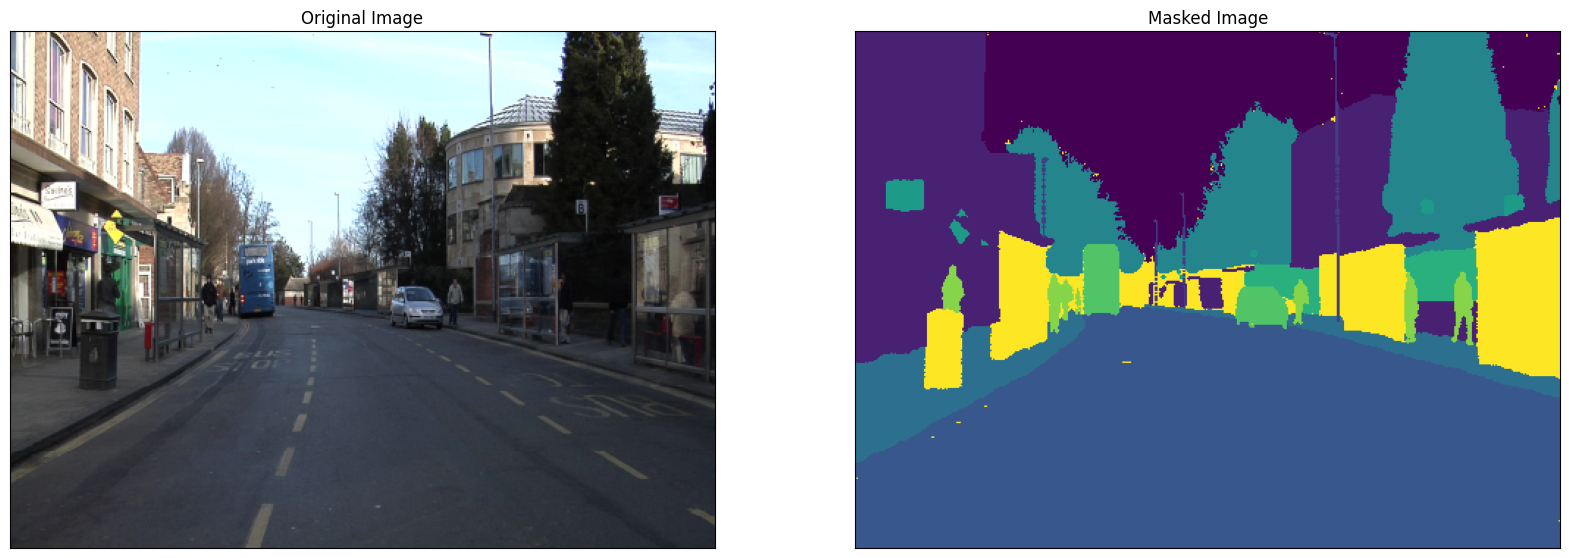

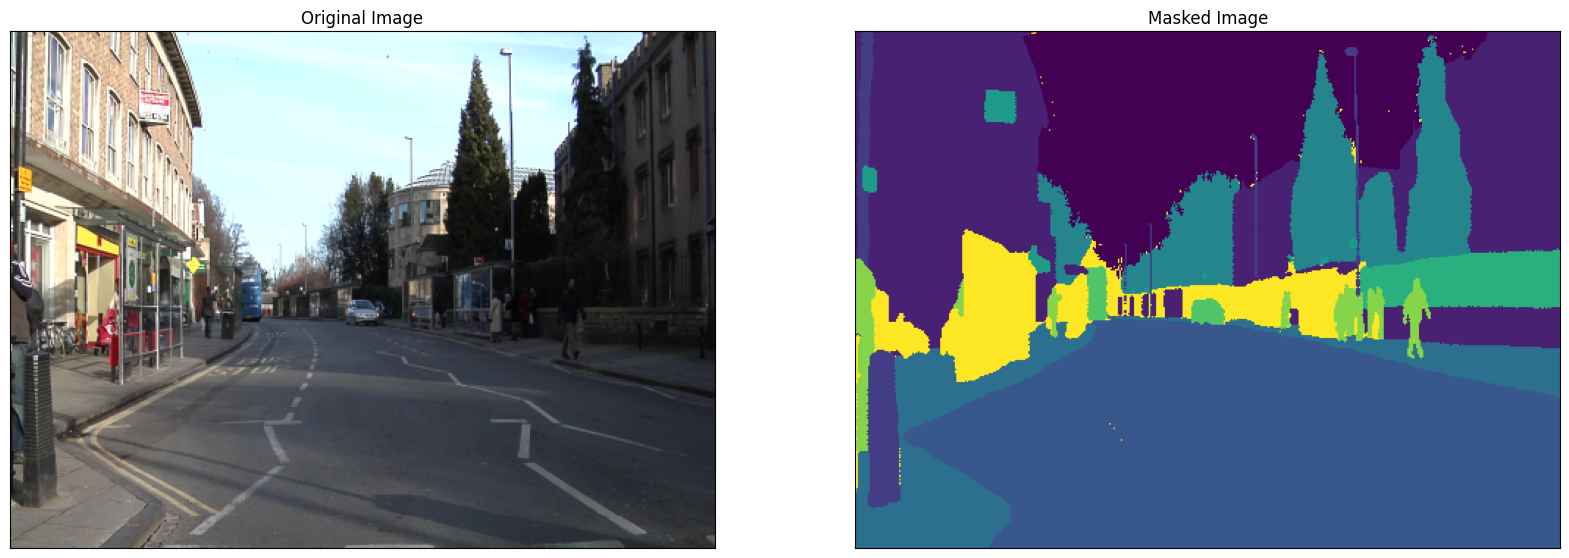

In [ ]:
N = 2

for index in range(N):

    image = train_images[index]
    mask = train_masks[index]

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])


    plt.subplot(1,2,2)
    plt.title("Masked Image")
    plt.imshow(tf.squeeze(mask))
    plt.xticks([])
    plt.yticks([])
    plt.show()

<a name='3'></a>
## 3 - U-Net

<a name='3-1'></a>
### 3.1 - Model Details

<center>
    <img src="https://drive.google.com/uc?export=view&id=1-umTBgUFnel5HvbaRNYuuOVMz-vVyxct">
</center>
<caption>
    <center>
        <u><b>Figure 2</u></b> : U-Net Architecture <br>
    </center>
</caption>


**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

<center>
    <img src="https://drive.google.com/uc?export=view&id=1ADyWwU70_we7jG3YDu51N76rdCXKSlqb">
</center>
<caption>
    <center>
        <u><b>Figure 3</u></b>: The U-Net Encoder up close <br>
    </center>
</caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.

In [ ]:
def conv_block(inputs=None, num_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        num_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv2d = Conv2D(num_filters,
                  (3, 3),
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(inputs)

    conv2d = Conv2D(num_filters,
                  (3, 3),
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv2d)


    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        dropout = Dropout(dropout_prob)(conv2d)
    else:
        dropout = conv2d


    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        maxpool = MaxPooling2D((2, 2), strides=2)(dropout)
    else:
        maxpool = dropout

    next_layer = maxpool
    skip_connection = dropout

    return next_layer, skip_connection

In [ ]:
input_shape = (128,128,3)
input = Input(shape=input_shape)

In [ ]:
conv_block_1=conv_block(input, num_filters=64, dropout_prob=0, max_pooling=True)
conv_block_2=conv_block(conv_block_1[0], num_filters=128, dropout_prob=0, max_pooling=True)
conv_block_3=conv_block(conv_block_2[0], num_filters=256, dropout_prob=0, max_pooling=True)
conv_block_4=conv_block(conv_block_3[0], num_filters=512, dropout_prob=0, max_pooling=True)

In [ ]:
output=conv_block_4[0]

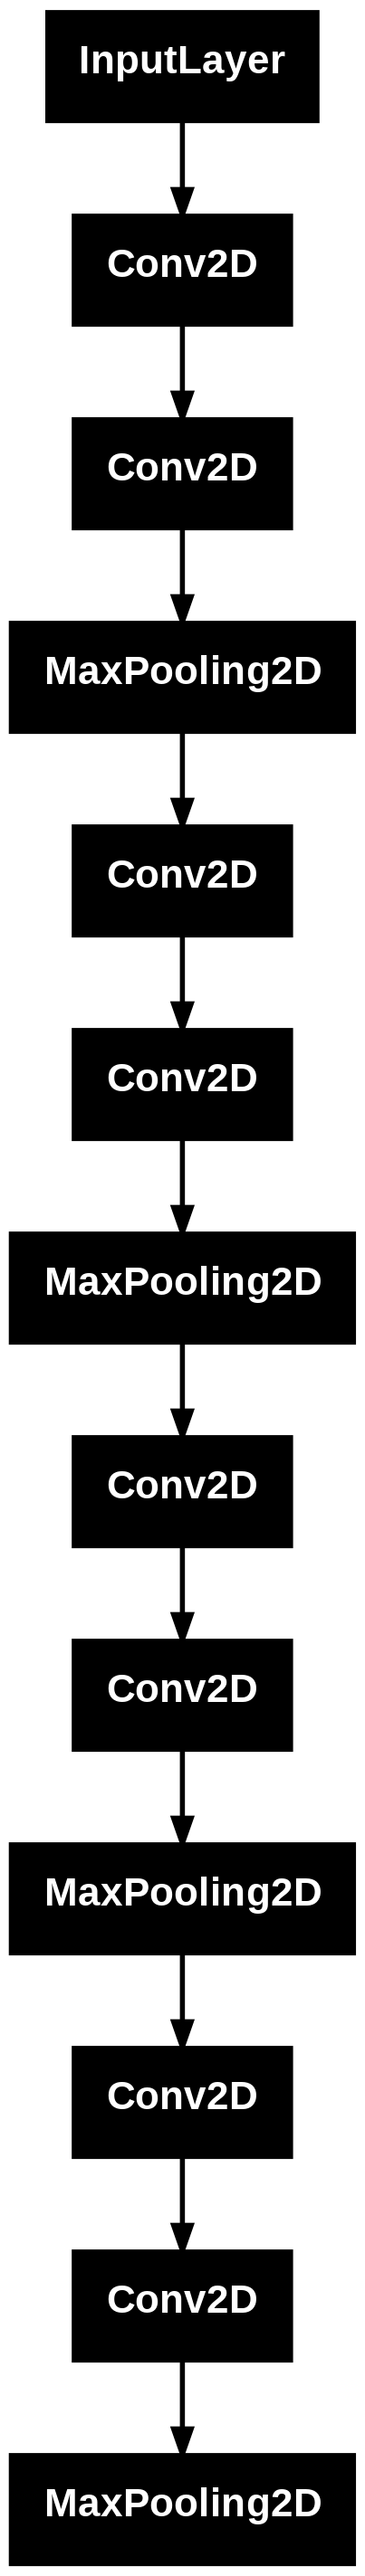

In [ ]:
model = tf.keras.Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model)

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<center>
    <img src="https://drive.google.com/uc?export=view&id=1pTCpyIZWBGwlKYQPuWrhGdjR1S4tl5fy">
</center>
<caption>
    <center>
        <u><b>Figure 4</u></b>: The U-Net Decoder up close <br>
    </center>
</caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


In [ ]:
def upsampling_block(expansive_input, contractive_input, num_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        num_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    upsampled_input = Conv2DTranspose(
                 num_filters,
                 (3, 3),
                 strides=2,
                 padding="same")(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([upsampled_input, contractive_input], axis=3)

    conv2d = Conv2D(num_filters,
                  (3, 3),
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(merge)

    conv2d = Conv2D(num_filters,
                  (3, 3),
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv2d)

    return conv2d

In [ ]:
upsampling_block(conv_block_4[0], conv_block_4[1], num_filters=512)

<KerasTensor shape=(None, 16, 16, 512), dtype=float32, sparse=False, name=keras_tensor_16>

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset.

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout` of 0.3
* For the final conv_block, set `dropout` to 0.3 again, and turn off max pooling. (Here `n_filters=n_filters* 16`)

For the second half:
* From here, at each step, use half the number of filters of the previous block
* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer.
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer.
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model.

In [ ]:
def unet_model(input_size=(None, None, 3), num_filters=32, num_classes=12):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        num_filters -- Number of filters for the convolutional layers
        num_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """

    inputs = Input(input_size)

    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and num_filters
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step

    conv_block_1 = conv_block(inputs=inputs, num_filters=num_filters * 1)
    conv_block_2 = conv_block(inputs=conv_block_1[0], num_filters=num_filters * 2)
    conv_block_3 = conv_block(inputs=conv_block_2[0], num_filters=num_filters * 4)

    # Include a dropout of 0.3 for this layer
    conv_block_4 = conv_block(inputs=conv_block_3[0], num_filters=num_filters * 8, dropout_prob=0.3)

    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    conv_block_5 = conv_block(inputs=conv_block_4[0], num_filters=num_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here, at each step, use half the number of filters of the previous block
    # Use the conv_block_5[0] as expansive_input and conv_block_4[1] as contractive_input and num_filters * 8

    deconv_block_6 = upsampling_block(conv_block_5[0], conv_block_4[1], num_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.

    deconv_block_7 = upsampling_block(deconv_block_6, conv_block_3[1], num_filters * 4)
    deconv_block_8 = upsampling_block(deconv_block_7, conv_block_2[1], num_filters * 2)
    deconv_block_9 = upsampling_block(deconv_block_8, conv_block_1[1], num_filters * 1)

    conv2d = Conv2D(num_filters,
                 (3, 3),
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(deconv_block_9)

    # Add a Conv2D layer with num_classes filter, kernel size of 1 and a 'same' padding
    outputs = Conv2D(num_classes, 1, padding="same")(conv2d)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [ ]:
height, width, channels = train_images[0].shape

unet = unet_model(input_size=(height, width, channels), num_filters=32, num_classes=12)

### Check out the model summary below!

In [ ]:
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 352, 480,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 352, 480,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 352, 480,  │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 176, 240,  │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 176, 240,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 176, 240,  │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 88, 120,   │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 88, 120,   │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 88, 120,   │    147,584 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 44, 60,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 44, 60,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 44, 60,    │    590,080 │ conv2d_16[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 44, 60,    │          0 │ conv2d_17[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 22, 30,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 22, 30,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 22, 30,    │  2,359,808 │ conv2d_18[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 22, 30,    │          0 │ conv2d_19[0][0] 

 Total params: 8,640,108 (32.96 MB)

 Trainable params: 8,640,108 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [ ]:
unet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

<a name='4'></a>
## 4 - Train the Model

In [ ]:
BATCH_SIZE = 8
EPOCHS = 40

model_history = unet.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True
)

Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7393 - loss: 0.7953
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 424ms/step - accuracy: 0.7664 - loss: 0.7310
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.7826 - loss: 0.6900
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.8085 - loss: 0.6188
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 438ms/step - accuracy: 0.8165 - loss: 0.5956
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.8364 - loss: 0.5343
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - accuracy: 0.8396 - loss: 0.5296
Epoch 8/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.8435 - loss: 0.5153
Epoch 9/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.8532 - loss: 0.4757
Epoch 10/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - accuracy: 0.8548 - loss: 0.4737
Epoch 11/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 446ms/step - accuracy: 0.8571 - loss: 0.4662
Epoch 12/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 41

<a name='4-1'></a>
### 4.1 - Plot Model Accuracy

Let's see how your model did!

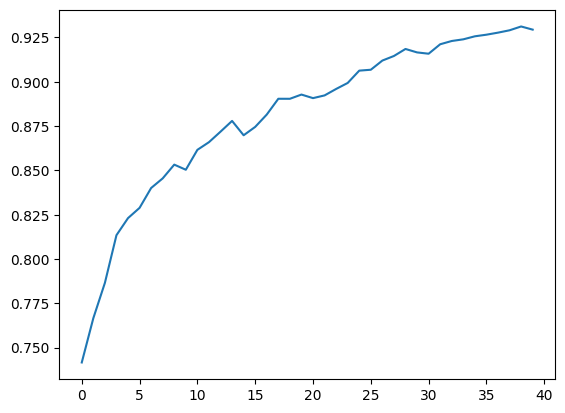

In [ ]:
plt.plot(model_history.history["accuracy"])

<a name='4-2'></a>
### 4.2 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [ ]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

<a name='4-3'></a>
### 4.3 - Create Predicted Masks

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-4'></a>
### 4.4 - Show Predictions

Next, check your predicted masks against the true mask and the original input image:

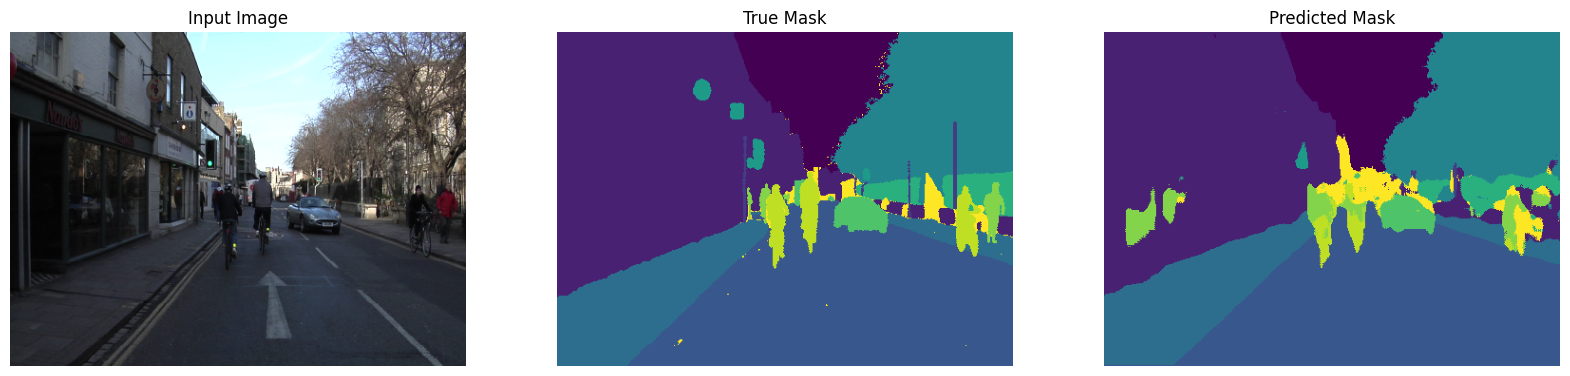

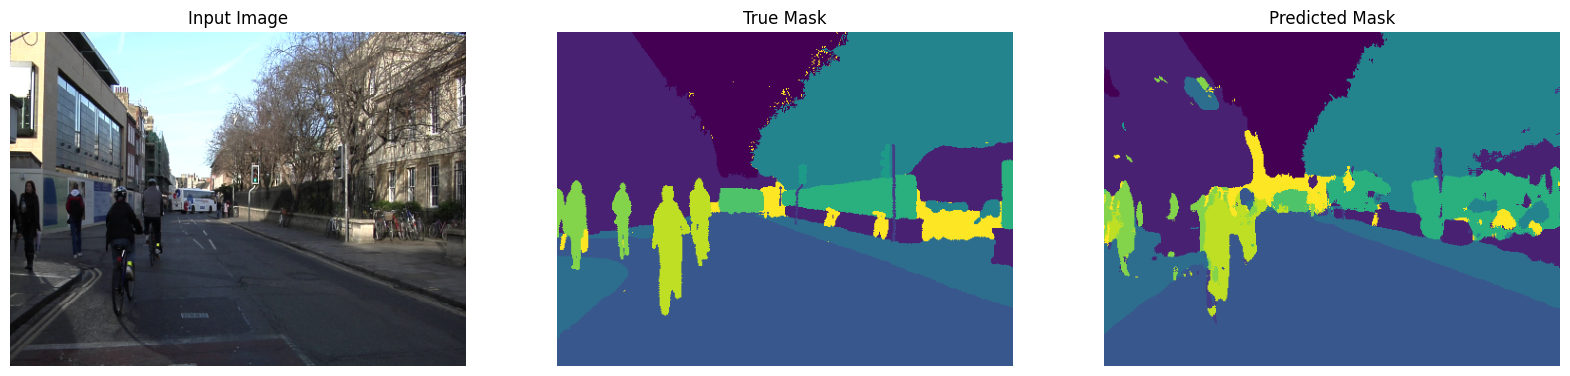

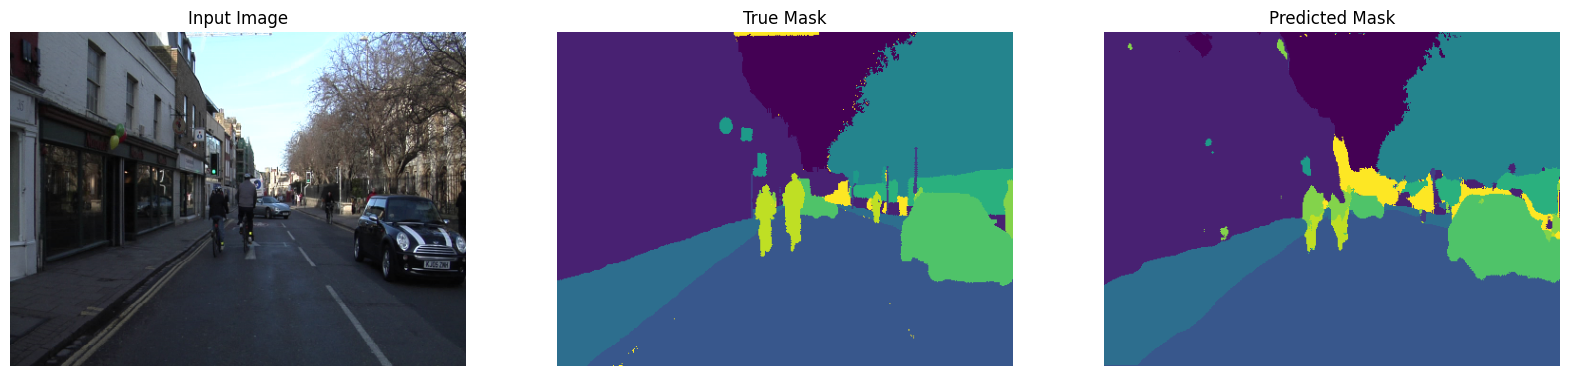

In [ ]:
for i in range(3):
    index = np.random.randint(test_images.shape[0])

    input_image = test_images[index]
    true_mask = test_masks[index]

    pred_mask = unet(tf.expand_dims(input_image, axis=0))
    pred_mask = create_mask(pred_mask)

    display([input_image, true_mask, pred_mask])

<font color='blue'>
    
**What you should remember**:

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net